In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
import XGBoost 
from XGBoost import SalesPredictionModel

In [3]:
f = yf.Ticker.get_info
f

<function yfinance.base.TickerBase.get_info(self, proxy=None, as_dict=False, *args, **kwargs)>

In [4]:
msft = yf.Ticker("aapl")
print(msft)

yfinance.Ticker object <AAPL>


In [5]:
msft.info

{'zip': '95014',
 'sector': 'Technology',
 'fullTimeEmployees': 100000,
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, iPod touch, and other Apple-branded and third-party accessories. It also provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store, that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand r

In [118]:
data = msft.history(period="max")

In [119]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [120]:
data = data.drop(columns=["Volume","Stock Splits","Dividends"])

In [121]:
data["mean_open_close"]=(data.loc[:,"Open"]+data.loc[:,"Close"])/2


In [122]:
data.head()

,Open,High,Low,Close,mean_open_close
Date,,,,,
1980-12-12,0.100751,0.101189,0.100751,0.100751,0.100751
1980-12-15,0.095933,0.095933,0.095495,0.095495,0.095714
1980-12-16,0.088923,0.088923,0.088485,0.088485,0.088704
1980-12-17,0.090676,0.091114,0.090676,0.090676,0.090676
1980-12-18,0.093304,0.093742,0.093304,0.093304,0.093304


In [123]:
data = data.drop(columns=["Open","High","Low","Close"])

In [124]:
def train_test_split(data, n_test):
    """
    Function to split dataset into train and test
        - data
        - n_test: desired number of rows in test dataset
    """
    return data[:-n_test].reset_index(drop=True), data[-n_test:].reset_index(drop=True)

In [125]:
def series_to_supervised(data,n_inputs=10,n_outputs=1):
    """
    Function to transform time-series data to supervised training data
        - data
        - n_inputs: Number of days to look back
        - n_outputs: Number of days to look after
        - dropnan
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    new_data = pd.DataFrame(data)
    columns, names = list(), list()
    # With this loop we extract the input values, i.e. the values of the variables
    # for the previous n_inputs time steps
    for i in range(n_inputs, 0, -1):
        columns.append(new_data.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    # With this loop we extract the actual values of the variables for the actual
    # time step and, if desired, we will add the next n_outputs time steps as columns
    for i in range(0, n_outputs):
        columns.append(new_data.shift(-i))  
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
    data_result = pd.concat(columns, axis=1)
    data_result.columns = names
    data_result.dropna(inplace=True)
    data_result = data_result.infer_objects()
    return data_result

In [128]:
data_final=series_to_supervised(data)
train,test=train_test_split(data_final,25)

In [129]:
train

,mean_open_close(t-10),mean_open_close(t-9),mean_open_close(t-8),mean_open_close(t-7),mean_open_close(t-6),mean_open_close(t-5),mean_open_close(t-4),mean_open_close(t-3),mean_open_close(t-2),mean_open_close(t-1),mean_open_close(t)
0,0.100751,0.095714,0.088704,0.090676,0.093304,0.098999,0.103817,0.108198,0.113892,0.124405,0.126158
1,0.095714,0.088704,0.090676,0.093304,0.098999,0.103817,0.108198,0.113892,0.124405,0.126158,0.123310
2,0.088704,0.090676,0.093304,0.098999,0.103817,0.108198,0.113892,0.124405,0.126158,0.123310,0.119806
3,0.090676,0.093304,0.098999,0.103817,0.108198,0.113892,0.124405,0.126158,0.123310,0.119806,0.120901
4,0.093304,0.098999,0.103817,0.108198,0.113892,0.124405,0.126158,0.123310,0.119806,0.120901,0.118492
...,...,...,...,...,...,...,...,...,...,...,...
10176,133.014069,134.546469,134.471581,133.717864,134.746130,131.396816,132.065671,129.300372,128.431852,128.596570,130.530006
10177,134.546469,134.471581,133.717864,134.746130,131.396816,132.065671,129.300372,128.431852,128.596570,130.530006,128.130001
10178,134.471581,133.717864,134.746130,131.396816,132.065671,129.300372,128.431852,128.596570,130.530006,128.130001,124.705002
10179,133.717864,134.746130,131.396816,132.065671,129.300372,128.431852,128.596570,130.530006,128.130001,124.705002,123.084999


In [133]:
train_X, train_y = train.drop('mean_open_close(t)', axis=1), train.drop(test.columns.difference(['mean_open_close(t)']), axis=1)
test_X, test_y = test.drop('mean_open_close(t)', axis=1), test.drop(test.columns.difference(['mean_open_close(t)']), axis=1)

In [167]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500,max_depth=10,reg_alpha=0.01)


In [168]:
model_xgb.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [169]:
test_X

,mean_open_close(t-10),mean_open_close(t-9),mean_open_close(t-8),mean_open_close(t-7),mean_open_close(t-6),mean_open_close(t-5),mean_open_close(t-4),mean_open_close(t-3),mean_open_close(t-2),mean_open_close(t-1)
0,131.396816,132.065671,129.300372,128.431852,128.596570,130.530006,128.130001,124.705002,123.084999,124.775002
1,132.065671,129.300372,128.431852,128.596570,130.530006,128.130001,124.705002,123.084999,124.775002,126.849998
2,129.300372,128.431852,128.596570,130.530006,128.130001,124.705002,123.084999,124.775002,126.849998,126.544998
3,128.431852,128.596570,130.530006,128.130001,124.705002,123.084999,124.775002,126.849998,126.544998,125.704998
4,128.596570,130.530006,128.130001,124.705002,123.084999,124.775002,126.849998,126.544998,125.704998,123.925003
5,130.530006,128.130001,124.705002,123.084999,124.775002,126.849998,126.544998,125.704998,123.925003,126.270000
6,128.130001,124.705002,123.084999,124.775002,126.849998,126.544998,125.704998,123.925003,126.270000,126.625000
7,124.705002,123.084999,124.775002,126.849998,126.544998,125.704998,123.925003,126.270000,126.625000,126.555000
8,123.084999,124.775002,126.849998,126.544998,125.704998,123.925003,126.270000,126.625000,126.555000,127.360001
9,124.775002,126.849998,126.544998,125.704998,123.925003,126.270000,126.625000,126.555000,127.360001,126.904999


In [170]:
a = model_xgb.predict(test_X)

In [171]:
a

array([127.29202 , 128.38023 , 128.21042 , 126.8551  , 121.82026 ,
       125.77928 , 128.86656 , 128.94232 , 129.51462 , 126.6254  ,
       126.35016 , 127.038216, 126.18583 , 128.4013  , 124.56933 ,
       126.090706, 126.84742 , 126.8274  , 129.47717 , 127.29222 ,
       125.75045 , 129.77379 , 129.8138  , 130.18166 , 130.59065 ],
      dtype=float32)

In [172]:
test_y

,mean_open_close(t)
0,126.849998
1,126.544998
2,125.704998
3,123.925003
4,126.270000
5,126.625000
6,126.555000
7,127.360001
8,126.904999
9,125.860001


In [173]:
mae = mean_absolute_error(test_y, a)
print(mae)

1.54182373046875


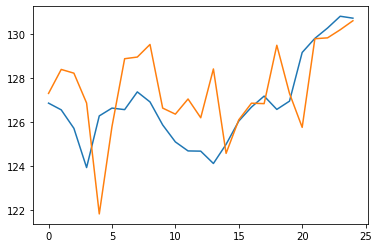

In [174]:
plt.plot(test_y.index,test_y)
plt.plot(a)

In [63]:
model=SalesPredictionModel(data, n_inputs=10, n_outputs=1)

In [65]:
model.preprocess()

ValueError: Invalid file path or buffer object type: <class 'pandas.core.frame.DataFrame'>

In [58]:
data

,mean_open_close
Date,
1980-12-12,0.100751
1980-12-15,0.095714
1980-12-16,0.088704
1980-12-17,0.090676
1980-12-18,0.093304
...,...
2021-06-14,129.149998
2021-06-15,129.790001
2021-06-16,130.259995
